The NO2 data is downloaded from EPA website:
https://www.epa.gov/outdoor-air-quality-data/download-daily-data

We picked pollutant NO2 concentration in California in 2020 as the sample for this project for two reasons:
1. In 2020, 8,648 fires burned 4,304,379 acres (1,741,920 ha), more than four percent of the state's roughly 100 million acres of land, making 2020 the largest wildfire season recorded in California's modern history. The 2020 California wildfires, which burned for over four months, were a major event that lasted from around mid-August to early January 2021.  (2020 California wildfires, Wikipedia)
2. After more than 118,000 cases in 114 countries and 4,291 deaths, the WHO declares COVID-19 a pandemic on March 11, 2020. The Trump Administration declares a nationwide emergency and issues an additional travel ban on non-U.S. citizens traveling from 26 European countries due to COVID-19 on March 13, 2020. California governor Gavin Newsom issues a statewide stay-at-home order to slow the spread of COVID-19 instructing residents to only leave their homes when necessary and shutting down all but essential businesses on March 19, 2020. (CDC Museum COVID-19 Timeline, 2024)

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

After looking through the csv file, here are some highlights of the csv file data:
1. There are 97 monitoring sites in California.
2. Each monitoring site records the concentration of NO2 every hour because NO2 is a highly reactive radical. The column named 'Daily Obs Count' shows how many hours are recorded during that day.
3. The EPA uses Daily Max 1-hour NO2 Concentration as a represent of daily concentration.
4. Several of these 97 monitoring sites have more than one device measuring the same NO2 pollutant. Here is the definition quote from EPA: "The column named 'POC' is the Parameter Occurrence Code and is used to uniquely identify a monitor if there is more than one device measuring the same pollutant at a site. The POC number assignment is somewhat arbitrary and varies between sites that are maintained by different state and local agencies. POC designation and monitor type are independent of each other." (https://www.epa.gov/outdoor-air-quality-data/what-does-poc-number-refer)
5. The year 2020 has 366 days, but not every single site has full 366 days of data. The majority of them have more than 350 days of data.

Based on the information above, we think filtering data is the first thing we need to do before any analysis. We need to filter the data for the following goals:
If there is more than one device measuring the same pollutant at the same site during the same day——that means there are multiple Daily Max 1-hour NO2 Concentration for the same monitoring site on the same day——we will need to take an average of all Daily Max 1-hour NO2 Concentrations in order to have one value for each site on each day.

Therefore, we filter the data in the following cell.

In [3]:
# Filter Data First------------------------------------------------------------------------

# Reading 2020 California Yearly NO2 Emission File
file_path = '../data/raw/EPA_ca_no2_2020_raw_data.csv'  # file Location
ca_no2_2020 = pd.read_csv(file_path + 'ca_no2_2020.csv')  # reading the CSV file

# Print the original column names so we know what the dataset looks like
# and can reference them correctly later.
print("original column names:")
print(ca_no2_2020.columns.tolist())

# Define new column names to make them easier to recall
station_col = "Site ID"
date_col = "Date"
no2_col = "Daily Max 1-hour NO2 Concentration"

# Convert the date column to datetime format that pandas can read
# so we can correctly group, sort, or filter by date later.
ca_no2_2020[date_col] = pd.to_datetime(ca_no2_2020[date_col])

# Groups the data by station and date. Computes the mean Daily Max 1-hour NO2 Concentrations for each group.
avg = (ca_no2_2020.groupby([station_col, date_col], as_index=False).agg({no2_col: 'mean'}))
# as_index=False keeps the results as normal columns instead of turning them into index labels.

# Creates a list of “other” columns—the ones we are not aggregating.
other_cols = [col for col in ca_no2_2020.columns if col not in [station_col, date_col, no2_col]]

# Groups again by station and date. For each group, takes the first value for all other columns.
# This makes all these other columns identical within each group.
df_first = (
    ca_no2_2020.groupby([station_col, date_col], as_index=False)[other_cols].first()
)

# Display ca_no2_2020 to see if everything is grouped correctly
display(ca_no2_2020.head())  # show first 5 row

# Merge the averaged Daily Max 1-hour NO2 Concentrations with the other columns.
new_2020 = pd.merge(avg, df_first, on=[station_col, date_col], how='left')
# This merges the mean Daily Max 1-hour NO2 Concentration (avg) and the “first values” of the other
# columns (df_first). So the result is one clean row per station per day.

# Display the cleaned DataFrame
print("\nFirst 5 rows of the cleaned DataFrame:") # show the first 5 rows for inspection
display(new_2020.head())

print("\nAll columns in the cleaned DataFrame:") # show the updated column list
print(new_2020.columns.tolist())

# Count how many sites are there in California
site_number = len(new_2020['Site ID'].unique())
print("\nNumber of sites:")
print(site_number)

original column names:
['Date', 'Source', 'Site ID', 'POC', 'Daily Max 1-hour NO2 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']


,Date,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,2020-01-01,AQS,60010007,1,18.5,ppb,17,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
1,2020-01-02,AQS,60010007,1,22.7,ppb,21,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
2,2020-01-03,AQS,60010007,1,23.6,ppb,22,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
3,2020-01-04,AQS,60010007,1,21.2,ppb,20,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
4,2020-01-05,AQS,60010007,1,23.0,ppb,22,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217



First 5 rows of the cleaned DataFrame:


,Site ID,Date,Daily Max 1-hour NO2 Concentration,Source,POC,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,AQS Parameter Description,Method Code,CBSA Code,CBSA Name,State FIPS Code,State,County FIPS Code,County,Site Latitude,Site Longitude
0,60010007,2020-01-01,18.5,AQS,1,ppb,17,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
1,60010007,2020-01-02,22.7,AQS,1,ppb,21,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
2,60010007,2020-01-03,23.6,AQS,1,ppb,22,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
3,60010007,2020-01-04,21.2,AQS,1,ppb,20,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217
4,60010007,2020-01-05,23.0,AQS,1,ppb,22,Livermore,23,96,...,Nitrogen dioxide (NO2),74,41860,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217



All columns in the cleaned DataFrame:
['Site ID', 'Date', 'Daily Max 1-hour NO2 Concentration', 'Source', 'POC', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']

Number of sites:
97


After filtering data, we want to plot the locations of monitoring sites on map using cartopy package

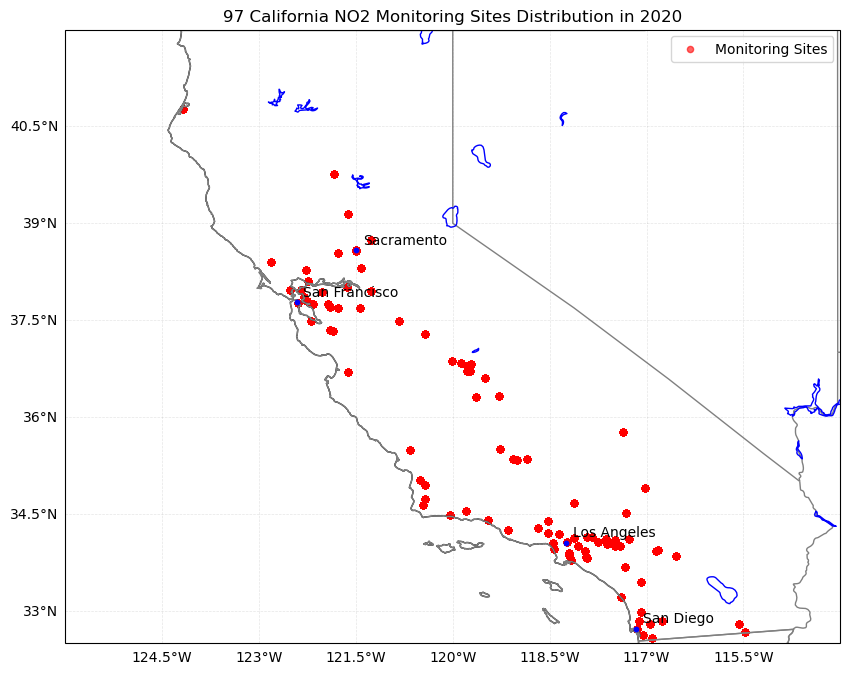

In [4]:
# Firstly, create the map figure
fig = plt.figure(figsize=(10, 8)) # Creates a figure with a width of 10 inches and height of 8 inches.
ax = plt.axes(projection=ccrs.PlateCarree())  # Uses the PlateCarree projection
ax.set_extent([-126, -114, 32.5, 42], crs=ccrs.PlateCarree())  # These bounds roughly frame the state of California.

# Add geographic features
coast = NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline') # means no filled interior—only outlines.
# coastline → National coast boundaries
states = NaturalEarthFeature(category='cultural', scale='10m',
                             facecolor='none', name='admin_1_states_provinces_lines')
# states → U.S. state boundary lines
lakes = NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='lakes')
# lakes → all lakes (North America + world)
countries = NaturalEarthFeature(category='cultural', scale='10m',
                                facecolor='none', name='admin_0_countries')
# countries → international borders

# Add the features onto the map
ax.add_feature(coast, edgecolor='black')
ax.add_feature(states, edgecolor='gray')
ax.add_feature(lakes, edgecolor='blue', facecolor='none')
ax.add_feature(countries, edgecolor='grey', facecolor='none')

# Plot the monitoring station locations as red scatters
scatter = ax.scatter(new_2020['Site Longitude'], new_2020['Site Latitude'],
                     transform=ccrs.PlateCarree(),
                     color='red', s=20, alpha=0.6, label='Monitoring Sites')

# Adding four major cities with their lats and lons as blue scatters,
# so we can better understand the locations
major_cities = {
    "San Francisco":  (37.7749, -122.4194),
    "Los Angeles":    (34.0522, -118.2437),
    "San Diego":      (32.7157, -117.1611),
    "Sacramento":     (38.5816, -121.4944),
}

# Add cities + labels using for loop
for city, (lat, lon) in major_cities.items():
    ax.scatter(lon, lat, color='blue', s=10, marker='o',
               transform=ccrs.PlateCarree(), zorder=5)    # plot every city with blue scatter
    ax.text(lon + 0.1, lat + 0.1, city, fontsize=10,
            transform=ccrs.PlateCarree())   # add names of cities

# Add title and gridlines
ax.set_title('97 California NO2 Monitoring Sites Distribution in 2020')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--')

# Turns off labels on the top and right sides to avoid clutter.
gl.top_labels = False
gl.right_labels = False

# Add legend
ax.legend()

# Show the plot
plt.show()

Now, we want to evaluate the NO2 air quality of California by the following questions:
1. If we compare Daily Max 1-hour NO2 Concentration among all sites with both the EPA standard and WHO standard, how many sites are above the standards?
2. If we take an average of all sites across the entire year, how many days are above the standards?

In order to answer the questions, we first found the EPA, WHO and California standards:

EPA Standard (National):
Hourly: 100 ppb (based on the 3-year average of 98th percentile of the yearly distribution of 1-hour daily maximum concentrations)
Annual: 53 ppb

WHO Standard:
Annual mean: 10 μg/m3
Daily: 25 μg/m3
Hourly: 200 μg/m3

California Standard (The California Air Resources Board):
Daily: 180 ppb
Yearly: 30 ppb


The EPA hourly and California daily standards are ridiculously high, so we decide to use annual standard of 53 ppb as the EPA reference and 30 ppb as the California reference. The WHO hourly standard is also pretty high, so we use daily standard of 25 μg/m3 as a reference.

The unit of our NO2 concentration is in ppb, so we convert the 25 μg/m3 WHO standard into ppb by the following formula:
$$ppb = \frac{(24.45 * 25 μg/m3)}{46.01 g/mol}$$
The number 24.45 in the equation is the volume (litres) of a mole (gram molecular weight) of a gas when the temperature is at 25°C and the pressure is at 1 atmosphere (1 atm = 1.01325 bar).
The number 46.01 g/mol is the molecular weight of NO2.

Now, we can play with data and make a graph to the answer for the first question.

WHO daily standard converted to: 13.3 ppb


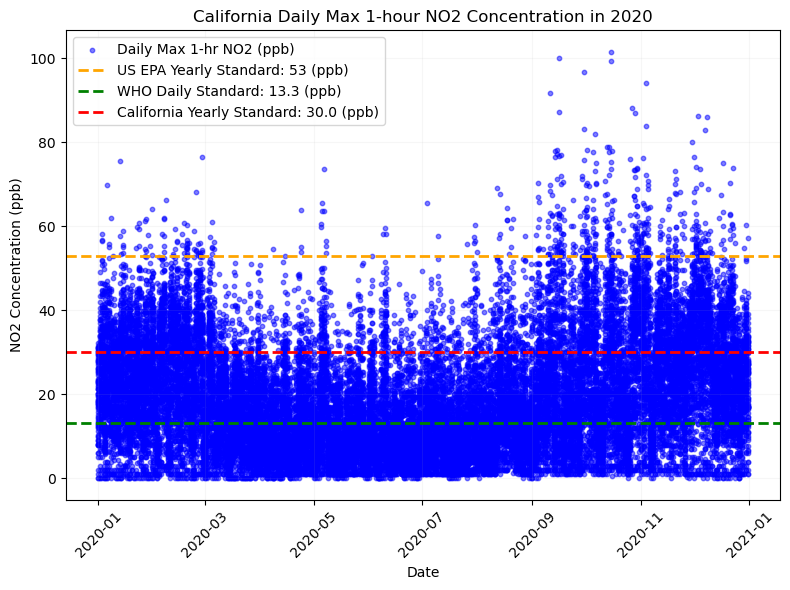

In [8]:
# We want to know if we compare Daily Max 1-hour NO2 Concentration among all sites with both the EPA standard and WHO standard, how many sites are above the standards?
# To answer this question, we decide to use a scatter plot to plot all Daily Max 1-hour NO2 Concentrations among all sites across the entire year. Then, add the standards to compare.

# Convert WHO Standard from μg/m³ to ppb
who_ug_m3 = 25  # WHO daily standard is 25 μg/m³
who_ppb = who_ug_m3 * 24.45 / 46.01 # Convert with formula stated in previous cell
epa_ppb = 53 # EPA yearly standard is 53 ppb
cal_ppb = 30 # California yearly standard is 53 ppb
# Print the WHO converted value to 1 decimal place.
print(f"WHO daily standard converted to: {who_ppb:.1f} ppb")

# There are a few negative Daily Max 1-hour NO2 Concentration values in the file,
# we need to remove rows where NO₂ concentration is negative.
filter_no2_2020 = new_2020[new_2020["Daily Max 1-hour NO2 Concentration"] >= 0]

# Plot the scatter plot of NO₂ values
plt.figure(figsize=(8, 6)) # create a new figure

# Make a scatter plot and each point represents one day at one station.
plt.scatter(filter_no2_2020['Date'], filter_no2_2020['Daily Max 1-hour NO2 Concentration'],
            alpha=0.5, color='blue', s=10, label='Daily Max 1-hr NO2 (ppb)')

# Add EPA and WHO horizontal standard lines
# Draw a horizontal dashed line at 53 ppb (EPA limit).
plt.axhline(y=epa_ppb, color='orange', linestyle='--', linewidth=2,
            label=f'US EPA Yearly Standard: {epa_ppb} (ppb)')
# Do the same for WHO.
plt.axhline(y=who_ppb, color='green', linestyle='--', linewidth=2, label=f'WHO Daily Standard: {who_ppb:.1f} (ppb)')
# Do the same for California standard
plt.axhline(y=cal_ppb, color='red', linestyle='--', linewidth=2, label=f'California Yearly Standard: {cal_ppb:.1f} (ppb)')

# Add plot labels and formatting
plt.xlabel('Date')
plt.ylabel('NO2 Concentration (ppb)')
plt.title('California Daily Max 1-hour NO2 Concentration in 2020')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.1)
plt.xticks(rotation=45) # Rotate x-axis labels
plt.tight_layout()
plt.show()

Analysis of this figure:

Overall distribution of NO₂ concentrations:

The majority of daily maximum NO₂ values fall between 0 and 40 ppb. A large cluster of points appears below 30 ppb, indicating that most areas maintain relatively low NO₂ even at their daily peak hour. A noticeable vertical spread exists on almost every date, demonstrating that NO₂ concentrations vary substantially between monitoring sites on the same day. There is also a seasonal pattern of higher concentration in fall and winter, lower concentration in spring and summer.

Comparison with health standards:

Although only a small number of sites exceed the EPA standard, a large portion of the sites is above the WHO standard. Roughly speaking, most sites exceed the WHO guideline on many days. But it also looks like the blue scatters are dense under 20 ppb, and higher concentration is more scattered. This will probably cause a lower average value. There are also a lot of points above the California standard.

This leads to our next question, if we take an average of all sites making it one daily average peak per day, will it look better?

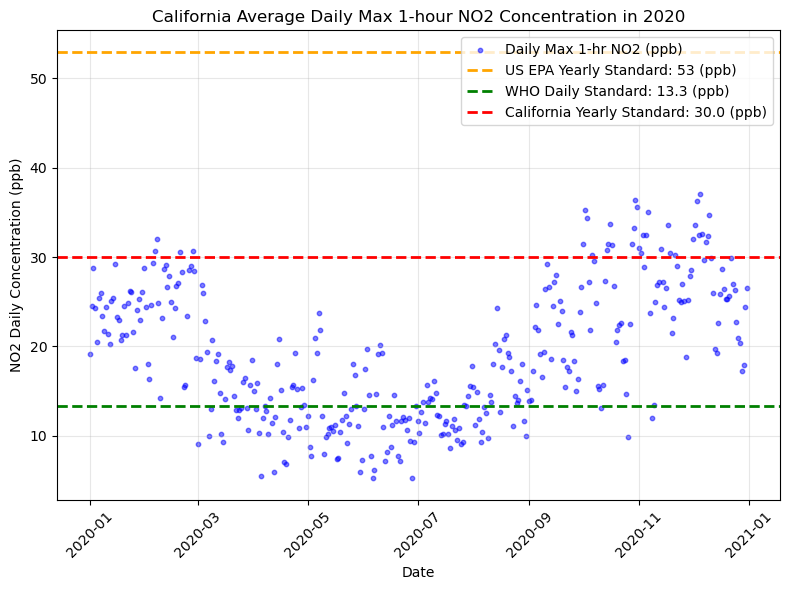

In [9]:
# Compute the average peak NO₂ concentration for each day using groupby
ave_daily_no2 = filter_no2_2020['Daily Max 1-hour NO2 Concentration'].groupby(filter_no2_2020['Date']).mean()
# This line groups the filtered NO₂ data by date. For each unique day, it computes the mean of all “Daily Max 1-hour NO₂ Concentration” values across all monitoring sites
# The result ave_daily_no2 is a Series where: the index = each date, the value = the average NO₂ concentration for that date

# Plot the daily averages using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(filter_no2_2020['Date'].unique(), ave_daily_no2,
            # use .unique() function because we only need each day in 2020 for the x-axis
            alpha=0.5, color='blue', s=10, label='Daily Max 1-hr NO2 (ppb)')
plt.axhline(y=epa_ppb, color='orange', linestyle='--', linewidth=2,
            label=f'US EPA Yearly Standard: {epa_ppb} (ppb)')
# y= parameter specifies where on the vertical axis the horizontal line should appear
plt.axhline(y=who_ppb, color='green', linestyle='--', linewidth=2, label=f'WHO Daily Standard: {who_ppb:.1f} (ppb)')
plt.axhline(y=cal_ppb, color='red', linestyle='--', linewidth=2, label=f'California Yearly Standard: {cal_ppb:.1f} (ppb)')

plt.xlabel('Date')
plt.ylabel('NO2 Daily Concentration (ppb)')
plt.title('California Average Daily Max 1-hour NO2 Concentration in 2020')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)  # Again, rotate x-axis labels
plt.tight_layout()
plt.show()


Analysis of this figure:

Overall distribution of NO₂ concentrations:

The statewide average exhibits a clear seasonal cycle, higher concentration in fall and winter, lower concentration in spring and summer.
Fall (Sep–Dec): Highest concentration during the year. Most values fall in 20–30+ ppb range.
Winter (Jan–Feb): Higher concentrations with most values fall in the 20–30 ppb range.
Spring (Mar–May): Lower concentration drop to roughly 10–20 ppb.
Summer (Jun–Aug): Lowest concentration with many days fall near 10–15 ppb.

Comparison with health standards:
The statewide averaged NO₂ value never comes close to the EPA standard. Even on polluted winter days, values remain far below the EPA limit. Many days exceed the WHO limit, especially during fall and winter. Days in mid-summer (June–August) generally fall at or below the WHO limit. The majority of points are above the California standard.

So far, we think the overall NO2 air quality of california still need improvement if compare with the WHO standard. The WHO standard is the real healthy standard, but there is still a big portions of days exceeding this limit. Since the 2020 california wildfire is the largest wildfire season recorded in California's modern history, but the NO2 concentration is far below the EPA limit, we hypothesize this discrepancy is attributed to the covid-19 lockdown.

In order to verify our hypothesis, we need to look at data from 3 years before 2020 and 3 years after 2020 to see any shift in pattern including the seasonal pattern that we see in this case.